In [1]:
from spectator_env import SpectatorEnv

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses or sigma:
        plt.subplot(122)
        plt.title('fidelity')
    if losses:
        plt.plot(losses, 'g')
    if sigma:
        plt.plot(sigma, 'r')
    plt.show()

In [4]:
# (action, reward) distribution for a given state
# in particular, we have two states: V0, V1
# @jitclass(spec)

class Context:
    def __init__(self, num_arms, gamma):
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.reward_posterior_samples = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)
        # discount factor
        self.gamma = gamma
        
    def resample_rewards(self):
        # ("Thompson") sampling from beta(S, F) distribution for each arm
        # which enables exploration
        for i in range(len(self.reward_posterior_samples)):
            self.reward_posterior_samples[i] = np.random.beta(self.S[i], self.F[i])

    def discount(self):
        self.S = self.gamma * self.S
        self.F = self.gamma * self.F
        
    def update_posterior(self, reward, arm):
        self.discount()
        self.S[arm] += reward
        self.F[arm] += 1-reward

class TS:
    def __init__(self, env, gamma=0.99):
        self.contexts = [Context(env.num_arms, gamma), Context(env.num_arms, gamma)]
        
        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []
        
        self.num_spectators = env.num_spectators
        
        
    def get_action(self, observation):
        # our context is an array of binary spectator qubit measurements
        # hence, we can convert this binary array to an integer and index 2^(spectator qubits) contexts
        # context = self.contexts[np.packbits(observation, bitorder='little')[0]]
        
        # simpler context
        context_idx = 1 if np.sum(observation) > self.num_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.resample_rewards()
        # (quantile, uniform action distribution, contextual measurement bias)
        return (np.argmax(context.reward_posterior_samples), [-np.pi, np.pi], 0)
    
    def update(self, action, reward, observation):
        arm, _, _ = action
        context_idx = 1 if np.sum(observation) > self.num_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.update_posterior(reward, arm)
            
    def save_reward(self, reward):
        self.rewards.append(reward)


    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)
        
    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)



In [15]:
M = 1000


# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
error_samples = np.random.uniform(-np.pi, np.pi, M) # + time_dependent_fn(np.arange(M))

In [16]:
# from stable_baselines.common.env_checker import check_env

env = SpectatorEnv(error_samples, num_spectators=64)

# It will check your custom environment and output additional warnings if needed
# check_env(env)

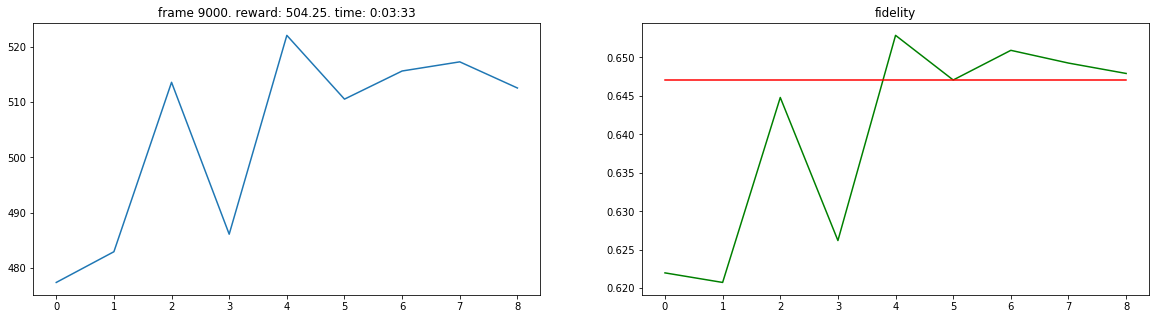

In [ ]:
start=timer()


# model = Model(env=env, config=config)

ts = TS(env, gamma=1.0)

episode_reward = 0
episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 10 * M # hence, we attempt learn 10 identical periods 

# "episodes" are a reasonable way to think about learning a periodic time dependent function
# max frames = episode length * num episodes
# episodes are identical sequences of training data
observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
#     epsilon = config.epsilon_by_frame(frame_idx)
    
    action = ts.get_action(observation)
    prev_observation = observation
#     print("prev obs: ", prev_observation)
#     print("action: ", action)
    observation, reward, done, info = env.step(action)
#     print("reward: ", reward)
    observation = None if done else observation

    # generally, in RL we would consider r(s | s', a) given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    ts.update(action, reward, prev_observation)
#     print(ts.contexts[0].S, ts.contexts[0].F)
#     print(ts.contexts[1].S, ts.contexts[1].F)
    episode_reward += reward
    
#     print(info)
    episode_fidelity.append(info[0])
    control_fidelity.append(info[1])

    if done:
        observation = env.reset()
        ts.save_reward(episode_reward)
        ts.save_fidelity(np.mean(episode_fidelity))
        ts.save_control_fidelity(np.mean(control_fidelity))
        episode_reward = 0
        episode_fidelity = []
        control_fidelity = []
        
        # plot grouped by episode
        plot(frame_idx, ts.rewards, ts.fidelity, ts.control_fidelity, timedelta(seconds=int(timer()-start)))
        

env.close()


In [13]:
print(ts.contexts[0].S, ts.contexts[0].F)

[1.04687500e+00 1.00000000e+00 2.07812500e+00 1.35937500e+00
 3.92187500e+00 3.15625000e+00 6.59375000e+00 2.32343750e+01
 3.66093750e+01 2.95546875e+02 4.01867188e+03 2.75484375e+02
 6.02187500e+01 1.77500000e+01 1.05937500e+01 4.85937500e+00
 1.54687500e+00 1.76562500e+00 1.15625000e+00 1.32812500e+00
 1.14062500e+00] [  3.953125   3.         3.921875   2.640625   4.078125   3.84375
   4.40625    6.765625   7.390625  25.453125 207.328125  22.515625
   8.78125    6.25       5.40625    5.140625   3.453125   3.234375
   3.84375    3.671875   2.859375]


In [14]:
print(ts.contexts[1].S, ts.contexts[1].F)

[1.34375000e+00 1.25000000e+00 1.14062500e+00 1.29687500e+00
 1.70312500e+00 2.07812500e+00 1.15625000e+01 3.17343750e+01
 2.68281250e+01 3.80515625e+02 3.75915625e+03 3.02562500e+02
 7.17187500e+01 1.10625000e+01 7.34375000e+00 4.21875000e+00
 3.40625000e+00 1.29687500e+00 1.03125000e+00 1.25000000e+00
 1.04687500e+00] [  3.65625    3.75       3.859375   2.703125   4.296875   3.921875
   6.4375     8.265625   7.171875  31.484375 207.84375   25.4375
  11.28125    4.9375     4.65625    4.78125    4.59375    3.703125
   3.96875    3.75       2.953125]
